# RNN with NodeAnalysis


In [1]:
from __future__ import print_function

import collections

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.keras import layers

import numpy as np
import tensorflow as tf 
import random
import time

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec, KeyedVectors, Phrases

from nodeanalysis.NodeAnalysis import NodeAnalysisCallback


## Pre-Processing

In [2]:
start_time = time.time()
def elapsed(sec):
    if sec<60:
        return str(sec) + " sec"
    elif sec<(60*60):
        return str(sec/60) + " min"
    else:
        return str(sec/(60*60)) + " hr"


# Target log path
logs_path = 'tmp'
#writer = tf.summary.FileWriter(logs_path)#this line was change to the line below by YKU on 05/18/20
#writer = tf.train.SummaryWriter(logs_path)
# Text file containing words for training
#training_file = '..\outputFiles\WordCountBytecodeHex.txt' the line was changed to the following line by YKU on 05/18/20
#training_file = 'outputFiles/WordCountBytecodeHex.txt'
training_file = 'inputFiles/The_D_of_I.txt'
#training_file = 'inputFiles/QuickBrownFox.txt'
#training_file = 'inputFiles/TwoSentences.txt'
#training_file = 'inputFiles/russian_text.txt'
def read_data(fname):
    with open(fname) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    content = [word for i in range(len(content)) for word in content[i].split()]
    content = np.array(content)
    return content

training_data = read_data(training_file)
print("Loaded training data...")

def build_dataset(words):
    count = collections.Counter(words).most_common()
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary

dictionary, reverse_dictionary = build_dataset(training_data)
vocab_size = len(dictionary)

# Parameters
learning_rate = 0.001
training_iters = 50000
display_step = 1000
# public static --> void main...
# basic words to be used for prediction, coming soon......
n_input = 3

# number of units in RNN cell
n_hidden = 512

Loaded training data...


## Pre-Processing that I Added

In [3]:
def encode(data, dictt):
    return [dictt[data[x]] for x in range(0,len(data))]

def group(data, num):
    result = []
    for i in range(0,len(data)-num+1):
        result.append([data[i+x] for x in range(0,num)])
    return result

def expand(groups, size):
    result = []
    while len(result) < size:
        for x in range(0,len(groups)):
            result.append(groups[x])
            if len(result) >= size:
                break
    return result

def seperate(groups, index):
    x = []
    y = []
    for a in range(0,len(groups)):
        x.append(groups[a][:index])
        y.append(groups[a][index:])
    return x, y

def batches(data, dictt, input_size, batch_size):
    x, y = seperate(expand(group(encode(data,dictt),input_size+1),batch_size),input_size)
    return np.array(x), np.array(y)

## Word2Vector

In [4]:
w2v_vector_dim = 25
w2v_epochs = 50
def w2v_model(data,num):
    global w2v_vector_dim
    global w2v_epochs

    w2v_data = group(data,num)
    model = Word2Vec(w2v_data, size=w2v_vector_dim, window=5, min_count=1, workers=4, iter=w2v_epochs)

    return model

print("starting to train word 2 vector model...")
w2v_input_size = 10
w2v = w2v_model(training_data, w2v_input_size)
w2v_dict = w2v.wv
print("word 2 vector model done training...")

starting to train word 2 vector model...
word 2 vector model done training...


## Keras Model

In [35]:
model = tf.keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
# model.add(layers.Embedding(vocab_size, 64, input_length=n_input)) <-- replaced by w2v
# model.add(layers.Dense(64, input_shape=(3,10)))
# Add a LSTM layer with 128 internal units.
# model.add(layers.LSTM(128))
new_shape = (n_input, w2v_vector_dim,)
# model.add(layers.Dense(64, input_shape=new_shape))


rnn_cell = tf.keras.layers.StackedRNNCells([tf.keras.layers.LSTMCell(n_hidden),tf.keras.layers.LSTMCell(n_hidden)])
# model.add(layers.RNN(rnn_cell, input_length=n_input))
model.add(layers.RNN(rnn_cell, input_shape=new_shape))
# Add a Dense layer with 10 units.
model.add(layers.Dense(len(dictionary)))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_2 (RNN)                  (None, 512)               3201024   
_________________________________________________________________
dense_2 (Dense)              (None, 627)               321651    
Total params: 3,522,675
Trainable params: 3,522,675
Non-trainable params: 0
_________________________________________________________________


## Prepare Batches

In [24]:
epochs = 50
batch_size_param = 1
batch_size = 1000*batch_size_param

dictt, reverse_dictt = build_dataset(training_data)
x_train, _ = batches(training_data, w2v_dict, n_input, batch_size)
(x_val, _) = batches(training_data, w2v_dict, n_input, batch_size*0.25)
(x_val2, _) = batches(training_data, dictt, n_input, batch_size*0.25)
_, y_train = batches(training_data, dictt, n_input, batch_size)
_, y_val = batches(training_data, dictt, n_input, batch_size*0.25)

print(x_train.shape)
print(y_train.shape)

model.compile(optimizer=tf.keras.optimizers.RMSprop(),  # Optimizer
              # Loss function to minimize
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # List of metrics to monitor
              metrics=['sparse_categorical_accuracy'])

print('# Fit model on training data')

(1000, 3, 25)
(1000, 1)
# Fit model on training data


## Tensorboard Callback

In [25]:
logs_path = "tb25"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_path, histogram_freq=1)

## Nodeanalysis Callback

In [26]:
nac = NodeAnalysisCallback()

## Model Training

In [27]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size_param,
                    epochs= 5, # epochs,
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    #validation_data=(x_val, y_val),
                    callbacks=[tensorboard_callback, nac])

Epoch 1/5
1000/1000 [==============================] - 91s 91ms/step - loss: 5.9663 - sparse_categorical_accuracy: 0.0420
Epoch 2/5
1000/1000 [==============================] - 90s 90ms/step - loss: 5.6713 - sparse_categorical_accuracy: 0.0660
Epoch 3/5
1000/1000 [==============================] - 85s 85ms/step - loss: 5.5905 - sparse_categorical_accuracy: 0.0710
Epoch 4/5
1000/1000 [==============================] - 86s 86ms/step - loss: 5.5599 - sparse_categorical_accuracy: 0.0690
Epoch 5/5
1000/1000 [==============================] - 88s 88ms/step - loss: 5.5118 - sparse_categorical_accuracy: 0.0720 5s - loss: 5.49 - ETA: 1s - loss: 5.5213 - sparse_catego


## Show Test Results

In [28]:
predictions = model.predict(x_val)

for x in range(0,len(predictions)):
    prediction = predictions[x]
    max = 0
    for i in range(0,len(prediction)):
        if prediction[i] > prediction[max]:
            max = i
    print(f'input: { [reverse_dictt[x_val2[x][i]] for i in range(0,len(x_val[x]))] } pred: {reverse_dictt[max]} --- actual: {[reverse_dictt[y_val[x][i]] for i in range(0,len(y_val[x]))] }')


input: ['When', 'in', 'the'] pred: of --- actual: ['Course']
input: ['in', 'the', 'Course'] pred: of --- actual: ['of']
input: ['the', 'Course', 'of'] pred: of --- actual: ['human']
input: ['Course', 'of', 'human'] pred: of --- actual: ['events']
input: ['of', 'human', 'events'] pred: of --- actual: ['it']
input: ['human', 'events', 'it'] pred: of --- actual: ['becomes']
input: ['events', 'it', 'becomes'] pred: of --- actual: ['necessary']
input: ['it', 'becomes', 'necessary'] pred: of --- actual: ['for']
input: ['becomes', 'necessary', 'for'] pred: of --- actual: ['one']
input: ['necessary', 'for', 'one'] pred: of --- actual: ['people']
input: ['for', 'one', 'people'] pred: of --- actual: ['to']
input: ['one', 'people', 'to'] pred: of --- actual: ['dissolve']
input: ['people', 'to', 'dissolve'] pred: of --- actual: ['the']
input: ['to', 'dissolve', 'the'] pred: of --- actual: ['political']
input: ['dissolve', 'the', 'political'] pred: of --- actual: ['bands']
input: ['the', 'political

## Results

### Accuracy

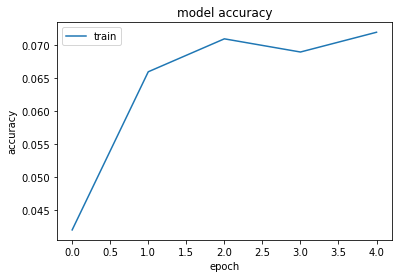

In [29]:
plt.plot(history.history['sparse_categorical_accuracy'])
# plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### Loss


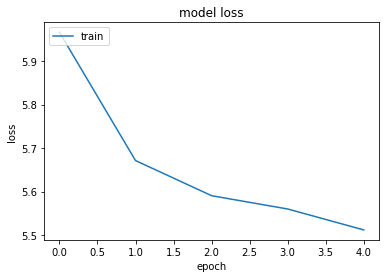

In [30]:
plt.title('model loss')
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## Duration


In [31]:
end_time = time.time()
print("duration: ",elapsed(end_time - start_time))

duration:  36.258439425627394 min


## NodeAnalysis

In [32]:
nac.nnlayer_names

['dense_1']

In [33]:
nac.layer_names

['rnn_1', 'dense_1']

In [36]:
print(len(nac.model.layers[0].get_weights()))

9
